## Introduzione al progetto

Lo scopo di questo progetto è quello di testare diverse tecnologie improntate sul paradigma del machine learning per generare un modello che sia in grado di espletare il task di "Autorship attribution".


Autorship Attribution è il problema di identificare l'autore di un determinato testo.
Da un punto di vista del Machine Learning, il problema è un problema di classificazione.

### Il dataset
Il dataset utilizzato è il  ["Fifty Victorian Era Novelists Authorship Attribution Data
"](https://dataworks.iupui.edu/handle/11243/23). Questo è il più grande datset di autorship attribution publicamente disponibile, e contiene i lavori di 50 autori dell'era vittoriana.
Ogni istanza è un testo di 1000 parole attribuite ad un singolo autore.

Abbiamo adottato un approccio di apprendimento supervisionato, in cui i modelli sono stati addestrati su un insieme di dati etichettati contenenti sia i testi che gli autori corrispondenti. Ciò ci ha permesso di costruire modelli in grado di generalizzare e predire gli autori di nuovi testi non appresi in fase di addestramento.

### Informazioni utili riguardanti questo notebook
Alcune sezioni saranno marcate con delle diciture:
1. [To run] indica che le celle di questa sezione non contengono informazioni utili per il progetto, ma solo sezioni di codice da eseguire
2. [Esperimento fallito] indica che le sezioni di codice non vanno eseguite in quanto per diversi motivi non è stato possibile concludere il processo di esecuzione (generalmente perchè impiegavano troppo tempo ad essere eseguite)

## Imports e utils [To run]

In [ ]:
!pip install scikit-optimize
!pip install seaborn


In [ ]:
# cambia il path con la cartella del progetto
PROJECT_FOLDER="./"

# Import
from google.colab import drive

from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV
import joblib
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import nltk
import re

# Download NLTK punkt tokenizer
nltk.download('punkt')
# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Utils

in questa sezione ci sono alcune funzioni che definisco per semplificare sezioni future.

In [ ]:
def preprocess_text(text):
    # Tokenization usando NLTK
    tokens = nltk.word_tokenize(text.lower())

    # Rimuovi stopwords and non-alphabetic tokens
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    return tokens


# Funzione per generare gli embeddings dei documenti usando Word2Vec
def get_doc_embedding(tokens):
    word_embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)


## Dataset pre processing

Il dataset ha solamente due colonne: 'text' e 'author' che indicano rispetivamente l'intera porzione di testo e l'autore dello stesso.
'Text' contiene porzioni di testo dell'autore. La lunghezza di queste porzioni di testo è omogenea per ogni istanza: contiene 1000 parole.

In [ ]:

# Load training dataset
dataset = pd.read_csv(PROJECT_FOLDER+'Gungor_2018_VictorianAuthorAttribution_data-train.csv', encoding='latin1')
dataset.head()



,text,author
0,ou have time to listen i will give you the ent...,1
1,wish for solitude he was twenty years of age a...,1
2,and the skirt blew in perfect freedom about th...,1
3,of san and the rows of shops opposite impresse...,1
4,an hour s walk was as tiresome as three in a s...,1


### Gestire le "class imbalances"
Come possiamo vedere dal grafico sottostante c'è uno sbilanciamento nel numero di istanze per ogni autore. Per esempio l'autore 8 ha quasi 7000 istanze associate, mentre autori come 27, 3 e 16 ne hanno solo qualche centinaio

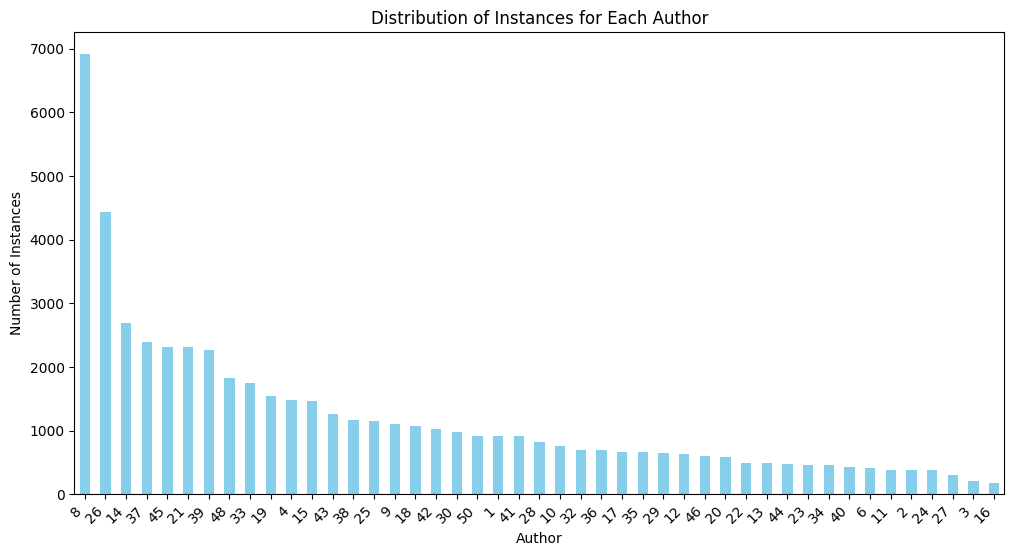

In [ ]:
# Conta occorrenze in ogni label
label_counts = dataset['author'].value_counts()

#print(dataset['author'].value_counts())

# Plotting the distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Instances for Each Author')
plt.xlabel('Author')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Come potremmo risolvere il problema
Questo problema potrebbe essere mitigato usando le tecniche di "undersampling" e "oversampling". Specialmente se si registrano problemi ricorrenti nelle classi meno numerose (come ad esempio una bassa precision) oppure con le classi più numerose (tipicamente un'alta precisione e una bassa recall).
Come vedremo in seguito questo non sarà necessario. Ma è comunque una strada da tenere a mente


### Text pre processing
La pre processazione del testo viene fatta come segue:

In [ ]:
# Tries to load data from project folder, reprocess the data if no processed text pickle is found

try:dataset['preprocessed_text'] = joblib.load(PROJECT_FOLDER+"data/preprocessed_text.pkl")
except: # Apply preprocessing to each document, uncomment if you want to reapply the pre processing from scratch
  print("except")
  dataset['preprocessed_text'] = dataset['text'].apply(preprocess_text)
  print("dump")
  #uncomment if you want to dump the newly preprocessed data and OVERRIDE THE PREVIOUS
  joblib.dump(dataset['preprocessed_text'],PROJECT_FOLDER+"data/preprocessed_text.pkl")

La funzione "preprocess_text" (che potete trovare nella sezione "Utils" di questo notebook) applica una tokenizzazione al testo:
utilizziamo il tokenizzatore di nltk in Python, che riconosce parole, punteggiatura e caratteri speciali, creando così una sequenza di token. Questi token costituiscono l'unità di base per l'analisi dei testi letterari, consentendo una rappresentazione strutturata e comprensibile per l'elaborazione da parte dei nostri modelli di machine learning.
Nel nostro caso abbiamo posto i token in lowercase, ed abbiamo eliminato caratteri non alfabetici, stop-words e punteggiatura.
trattandosi di un dataset omogeneo in lingua inglese abbiamo usato il corpuS "english".

In [ ]:
dataset.head()

,text,author,preprocessed_text
0,ou have time to listen i will give you the ent...,1,"[ou, time, listen, give, entire, story, said, ..."
1,wish for solitude he was twenty years of age a...,1,"[wish, solitude, twenty, years, age, possessio..."
2,and the skirt blew in perfect freedom about th...,1,"[skirt, blew, perfect, freedom, upper, parts, ..."
3,of san and the rows of shops opposite impresse...,1,"[san, rows, shops, opposite, impressed, upon, ..."
4,an hour s walk was as tiresome as three in a s...,1,"[hour, walk, tiresome, three, sensible, englis..."


Sopra si può vedere il risultato della tokenizzazione.

---



###Split Data

Divido il dataset in tre split: Train, val e test.
Questo tipo di split ci permette di valutare il modello su dati che non ha mai visto. Un ulteriore split ci permette di usare dati per valutare gli iperparametri, senza incorrere nel rischio di adattare gli iperparametri stessi ai dati su cui poi verrà testato definitivamente il modello.

Ricapitolando. Train, val e test Verranno utilizzati rispettivamente per:
1. Addestrare i modelli
2. Valutare gli iperparametri del modello
3. Testare la bontà del modello nella fase finale

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary data (combined validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(dataset['preprocessed_text'], dataset['author'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



## Feature Extraction
Adesso che abbiamo dato un'occhiata al dataset e lo abbiamo preprocessato, possiamo pensare alla fase di "feature extraction".
Feature extraction è il processo di trasformare dati in un insieme di features numerici che possono essere usati per rappresentare e caratterizzare l'informazione contenuta nei dati.
Nel contesto del machine learning, feature extraction è un passo cruciale per convertire dati complessi e spesso altamente dimensionali in un formato che sia addatto per addestare un modello.

Proveremo alcune delle più usate tecniche di vettorizzazione e le testeremo usando il classificatore Naive Bayes per capire quali tra i possibili embeddings è il più adatto per questo task.

Nel corso di questo progetto, ci siamo avvalsi di due diversi metodi di feature extraction per trasformare il testo in formati comprensibili per i modelli di apprendimento automatico: word 2 vec e TF-idf.

### Word2Vec

Word2Vec è un modello di rappresentazione semantica delle parole introdotto da Tomas Mikolov e il suo team presso Google nel 2013. L'obiettivo principale di Word2Vec è quello di catturare relazioni semantiche e sintattiche tra parole in un modo che preserva il significato delle parole all'interno di un contesto.

Questo metodo rappresenta le parole in uno spazio vettoriale in modo che vocaboli simili siano collocati vicini tra loro. Word2Vec cattura il contesto e il significato semantico delle parole attraverso l'apprendimento di vettori densi, convertendole in vettori numerici che conservano informazioni sulle relazioni semantiche che sussistono tra loro.

Word2Vec è considerato un modello che riesce, generalmente, a performare meglio di un approccio bag of words, ed il motivo per cui è il primo di questa lista è che purtroppo, le performance applicate a questo particolare task sono deludenti

In [ ]:

# Addestro Word2Vec
try:word2vec_model=joblib.load(PROJECT_FOLDER+'embeddings_models/word2vec_model_100vecsize.pkl')
except:
  word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)
  # Dump the model
  joblib.dump(word2vec_model,PROJECT_FOLDER+'embeddings_models/word2vec_model_100vecsize.pkl')


# Genero gli embedding per ogni documento
X_train_word2vec = [get_doc_embedding(tokens) for tokens in X_train]
X_val_word2vec = [get_doc_embedding(tokens) for tokens in X_val]

In [ ]:
print("numero di documenti",len(X_val_word2vec),"\nDimensioni del vettore",len(X_val_word2vec[0]))

numero di documenti 8052 
Dimensioni del vettore 100


In questo codice abbiamo addestrato Word2Vec per rappresentare il testo in vettori di size 100. Abbiamo esportato il modello (per evitare di doverlo addestrare tuttel le volte).
Ora che abbiamo creato gli embedding con word2vec andiamo ad usare Logistic Regression per classificare il testo.

In [ ]:

# Train Word2Vec
try:word2vec_model=joblib.load(PROJECT_FOLDER+'embeddings_models/word2vec_model_100vecsize.pkl')
except:
  word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)
  joblib.dump(word2vec_model,PROJECT_FOLDER+'embeddings_models/word2vec_model_100vecsize.pkl')

# Train Logistic Regression classifier on Word2Vec vectors
try:logistic_regression_classifier_word2vec=joblib.load(PROJECT_FOLDER+'classifiers/logistic_regression_classifier_word2vec100.pkl')
except:
  logistic_regression_classifier_word2vec = LogisticRegression(max_iter=1000)
  logistic_regression_classifier_word2vec.fit(X_train_word2vec, y_train)
  joblib.dump(logistic_regression_classifier_word2vec,PROJECT_FOLDER+'classifiers/logistic_regression_classifier_word2vec100.pkl')

# Predictions on the validation set using Word2Vec
val_predictions_word2vec = logistic_regression_classifier_word2vec.predict(X_val_word2vec)

# Evaluate the Word2Vec model with Logistic Regression
accuracy_word2vec = accuracy_score(y_val, val_predictions_word2vec)
print("\nLogistic Regression + Word2Vec Accuracy:", accuracy_word2vec)
print("\nClassification Report (Word2Vec):")
print(classification_report(y_val, val_predictions_word2vec))


Logistic Regression + Word2Vec Accuracy: 0.7878787878787878

Classification Report (Word2Vec):
              precision    recall  f1-score   support

           1       0.79      0.85      0.82       135
           2       0.50      0.30      0.37        57
           3       0.95      0.49      0.64        39
           4       0.67      0.59      0.63       230
           6       0.76      0.45      0.57        62
           8       0.81      0.88      0.84      1049
           9       0.67      0.65      0.66       161
          10       0.88      0.76      0.81       132
          11       0.79      0.58      0.67        53
          12       0.78      0.70      0.74        88
          13       0.80      0.65      0.72        74
          14       0.78      0.88      0.83       386
          15       0.82      0.89      0.85       223
          16       0.67      0.36      0.47        22
          17       0.57      0.56      0.57       107
          18       0.69      0.62      

Questo risultato è già abbastanza soddsfacente, ma possiamo fare di meglio. Innanzitutto possiamo aumentare il numero di feature (che in questo momento è 100) per cercare di catturare pattern semantici più significativi.

#### Word2Vec con più componenti

In questo caso aabiamo addestrato Word2Vec per rappresentare i token con vettori di 500 features.


In [ ]:

# Train Word2Vec
try:word2vec_model=joblib.load(PROJECT_FOLDER+'embeddings_models/word2vec_model_500vecsize.pkl')
except:
  word2vec_model = Word2Vec(sentences=X_train, vector_size=500, window=5, min_count=1, workers=4)
  joblib.dump(word2vec_model,PROJECT_FOLDER+'embeddings_models/word2vec_model_500vecsize.pkl')

# Train Logistic Regression classifier on Word2Vec vectors
try:logistic_regression_classifier_word2vec=joblib.load(PROJECT_FOLDER+'classifiers/logistic_regression_classifier_word2vec500.pkl')
except:
  logistic_regression_classifier_word2vec = LogisticRegression(max_iter=1000)
  logistic_regression_classifier_word2vec.fit(X_train_word2vec, y_train)
  joblib.dump(logistic_regression_classifier_word2vec,PROJECT_FOLDER+'classifiers/logistic_regression_classifier_word2vec500.pkl')

# Predictions on the validation set using Word2Vec
val_predictions_word2vec = logistic_regression_classifier_word2vec.predict(X_val_word2vec)

# Evaluate the Word2Vec model with Logistic Regression
accuracy_word2vec = accuracy_score(y_val, val_predictions_word2vec)
print("\nLogistic Regression + Word2Vec Accuracy:", accuracy_word2vec)
print("\nClassification Report (Word2Vec):")
print(classification_report(y_val, val_predictions_word2vec))


Logistic Regression + Word2Vec Accuracy: 0.7878787878787878

Classification Report (Word2Vec):
              precision    recall  f1-score   support

           1       0.79      0.85      0.82       135
           2       0.50      0.30      0.37        57
           3       0.95      0.49      0.64        39
           4       0.67      0.59      0.63       230
           6       0.76      0.45      0.57        62
           8       0.81      0.88      0.84      1049
           9       0.67      0.65      0.66       161
          10       0.88      0.76      0.81       132
          11       0.79      0.58      0.67        53
          12       0.78      0.70      0.74        88
          13       0.80      0.65      0.72        74
          14       0.78      0.88      0.83       386
          15       0.82      0.89      0.85       223
          16       0.67      0.36      0.47        22
          17       0.57      0.56      0.57       107
          18       0.69      0.62      

Come possiamo notare, le prestazioni sono esattamente le stesse.
Questo può essere spiegato con diverse ipotesi:
1. Ridondanza delle features: Potrebbe esserci una notevole ridondanza tra le features aggiunte al superare la soglia di 100 features. In altre parole, le features aggiuntive potrebbero non aggiungere informazioni significative al modello.
2. Modello troppo complesso: Potrebbe essere che il modello utilizzato sia troppo complesso per il problema o che sia soggetto a overfitting, rendendo le differenze tra 100 e 500 features trascurabili.
3. Configurazione del modello: La configurazione specifica del modello o degli iperparametri potrebbe non essere sensibile alle differenze tra 100 e 500 features.

In ogni caso non ho esplorato queste ipotesi, principalmente perchè il modello TF-idf performa in maniera molto migliore per questo particolare task come possiamo vedere nella sezione successiva.

### TF-idf

TF-IDF, che sta per Term Frequency-Inverse Document Frequency, è una tecnica di pesatura utilizzata nell'elaborazione del linguaggio naturale e nell'information retrieval. In breve, misura l'importanza di una parola in un documento rispetto a una collezione più ampia di documenti. L'idea di base è che una parola è più significativa per un documento se appare frequentemente in quel documento, ma è meno significativa se appare in molti documenti.

La formula di TF-IDF è composta da:
il Term Frequency (TF) e l'Inverse Document Frequency (IDF). La formula completa è data da:
$$
 \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$
Dove:

- \( t \) è il termine (parola) di interesse.
- \( d \) è il documento in cui stiamo calcolando il TF-IDF.
- \( D \) è l'insieme di tutti i documenti nel corpus.

La Term Frequency (TF) è calcolata come:

$ \text{TF}(t, d) = \frac{\text{Numero di volte che il termine } t \text{ appare in } d}{\text{Numero totale di termini in } d} $

L'Inverse Document Frequency (IDF) è calcolato come:

$ \text{IDF}(t, D) = \log\left(\frac{\text{Numero totale di documenti in } D}{\text{Numero di documenti in cui il termine } t \text{ appare} + 1}\right) + 1 $

Il "+1" nel denominatore del termine IDF evita il problema della divisione per zero quando un termine compare in tutti i documenti.

Quindi, moltiplicando TF per IDF otteniamo il punteggio finale del TF-IDF per un dato termine in un documento specifico.


In [ ]:

X_train=[' '.join(tokens) for tokens in X_train]
X_val =[' '.join(tokens) for tokens in X_val]
X_test =[' '.join(tokens) for tokens in X_test]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Adesso che abbiamo vettorizzato possiamo guardare ai risultati di logistic regression:

In [ ]:
try:logistic_regression_classifier_tfidf = joblib.load(PROJECT_FOLDER+"classifiers/logistic_regression_classifier_tfidf.pkl")
except:
  # Train Logistic Regression classifier on TF-IDF vectors
  logistic_regression_classifier_tfidf = LogisticRegression(max_iter=1000)
  logistic_regression_classifier_tfidf.fit(X_train_tfidf, y_train)
  joblib.dump(logistic_regression_classifier_tfidf,PROJECT_FOLDER+"classifiers/logistic_regression_classifier_tfidf.pkl")

# Predictions on the validation set using TF-IDF
val_predictions_tfidf = logistic_regression_classifier_tfidf.predict(X_val_tfidf)

# Evaluate the TF-IDF model with Logistic Regression
accuracy_tfidf = accuracy_score(y_val, val_predictions_tfidf)
print("Logistic Regression + TF-IDF Accuracy:", accuracy_tfidf)
print("\nClassification Report (TF-IDF):")
print(classification_report(y_val, val_predictions_tfidf))

Logistic Regression + TF-IDF Accuracy: 0.9298310978638847

Classification Report (TF-IDF):
              precision    recall  f1-score   support

           1       0.96      0.95      0.95       135
           2       1.00      0.56      0.72        57
           3       1.00      0.69      0.82        39
           4       0.88      0.81      0.85       230
           6       0.96      0.69      0.80        62
           8       0.88      0.97      0.93      1049
           9       0.96      0.96      0.96       161
          10       0.98      0.92      0.95       132
          11       0.93      0.74      0.82        53
          12       0.94      0.94      0.94        88
          13       1.00      0.78      0.88        74
          14       0.95      0.99      0.97       386
          15       0.96      0.97      0.97       223
          16       0.90      0.41      0.56        22
          17       0.95      0.82      0.88       107
          18       0.92      0.96      0.94 

In [ ]:
print(X_val_tfidf.shape)

(8052, 5000)


Come si può vedere, c'è un netto miglioramento della performance usando TF-IDF per questo task

Questo risultato non è del tutto sorprendente per vari motivi:
in primo luogo c'è una grossa differenza in dimensionalità. In secondo luogo, per certi versi, un approccio strettamente legato alla semantica, come word2Vec può rivelarsi meno efficace in contesti in cui la semantica del testo non è così rilevante come la vera e propria presenza di una o più parole.
Ad esempio, è molto più rilevante che il nome di un personaggio appaia o meno in un testo e non tanto il contesto semantico in cui quel nome appare.

Proviamo a confermare questa ipotesi vedendo quali sono i termini più informativi:

In [ ]:
import numpy as np

# Estrarre i coefficienti del modello
coefficients = logistic_regression_classifier_tfidf.coef_[0]

# Mappare i coefficienti alle parole corrispondenti nel TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients_mapping = dict(zip(feature_names, coefficients))

# Ordinare i coefficienti per valore assoluto in ordine decrescente
sorted_coefficients = sorted(coefficients_mapping.items(), key=lambda x: abs(x[1]), reverse=True)

# Ottenere le probabilità predette per ogni classe
predicted_probabilities = logistic_regression_classifier_tfidf.predict_proba(X_val_tfidf)

# Trovare la classe predetta con la probabilità più alta per ciascuna istanza
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Creare un dizionario per tenere traccia del termine più informativo per ogni classe
most_informative_terms = {i: {'term': None, 'coefficient': None} for i in range(logistic_regression_classifier_tfidf.coef_.shape[0])}

# Iterare sui coefficienti e assegnare il termine più informativo per ciascuna classe
for term, coefficient in sorted_coefficients:
    for i in range(logistic_regression_classifier_tfidf.coef_.shape[0]):
        if most_informative_terms[i]['term'] is None and most_informative_terms[i]['coefficient'] is None:
            most_informative_terms[i]['term'] = term
            most_informative_terms[i]['coefficient'] = coefficient
            break

# Stampare i termine più informativi per ogni classe
for i in range(logistic_regression_classifier_tfidf.coef_.shape[0]):
    print(f"Classe {i}: Termine più informativo: {most_informative_terms[i]['term']}, Coefficiente: {most_informative_terms[i]['coefficient']}")


Classe 0: Termine più informativo: girl, Coefficiente: 3.9859450840460253
Classe 1: Termine più informativo: young, Coefficiente: 3.476601627959732
Classe 2: Termine più informativo: sugar, Coefficiente: 3.4435779710014125
Classe 3: Termine più informativo: marriage, Coefficiente: 3.3028926610284848
Classe 4: Termine più informativo: responded, Coefficiente: 3.1456814386364753
Classe 5: Termine più informativo: husband, Coefficiente: 3.1299564574844645
Classe 6: Termine più informativo: gray, Coefficiente: 3.1185592812587064
Classe 7: Termine più informativo: mr, Coefficiente: 3.067063695698943
Classe 8: Termine più informativo: asked, Coefficiente: 2.937157468457657
Classe 9: Termine più informativo: reply, Coefficiente: 2.9262208017186166
Classe 10: Termine più informativo: princess, Coefficiente: 2.6929451063467185
Classe 11: Termine più informativo: hotel, Coefficiente: 2.6827401754444344
Classe 12: Termine più informativo: love, Coefficiente: 2.6407329995431486
Classe 13: Termine 

Questi sono i termini che hanno una maggiore informatività per ogni classe.
 In modo intuitivo, si può considerare il coefficiente come indicatore di quanto il termine influenzi la probabilità di appartenenza a una classe rispetto alle altre. Un coefficiente positivo suggerisce che un aumento nel conteggio di quel termine è associato a un aumento nelle probabilità di appartenenza a una determinata classe, mentre un coefficiente negativo suggerisce l'opposto.

Quindi, se si ha un termine con un coefficiente positivo elevato, significa che la presenza di quel termine è fortemente associata alla classe positiva (o all'autore specifico in questo caso), mentre un termine con un coefficiente negativo elevato indica una forte associazione con la classe negativa.

#### Dimensionality reduction

Il prossimo step sarà quello di concatenare tf-idf con altri metodi di feature selection. Per questo è necessario ridurre almeno in parte la dimensione dei vettori (che finora è di 5000 features!)

In [ ]:

# Choose the number of components you want after PCA
num_components = 100

# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train Logistic Regression on the PCA-transformed features
try: logistic_regression_classifier_pca = joblib.load(PROJECT_FOLDER+"classifiers/logistic_regression_classifier_tfidf_100.pkl")
except:
  logistic_regression_classifier_pca = LogisticRegression(max_iter=1000)
  logistic_regression_classifier_pca.fit(X_train_tfidf_pca, y_train)
  joblib.dump(logistic_regression_classifier_pca,PROJECT_FOLDER+"classifiers/logistic_regression_classifier_tfidf_100.pkl")

# Predictions on the validation set using PCA
val_predictions_pca = logistic_regression_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca = accuracy_score(y_val, val_predictions_pca)
print("Logistic Regression + PCA Accuracy:", accuracy_pca)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca))


Logistic Regression + PCA Accuracy: 0.6810730253353204

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.72      0.72      0.72       135
           2       1.00      0.07      0.13        57
           3       0.83      0.13      0.22        39
           4       0.52      0.45      0.48       230
           6       0.78      0.29      0.42        62
           8       0.61      0.88      0.72      1049
           9       0.62      0.46      0.53       161
          10       0.85      0.51      0.64       132
          11       0.73      0.45      0.56        53
          12       0.82      0.56      0.66        88
          13       0.78      0.34      0.47        74
          14       0.69      0.74      0.71       386
          15       0.66      0.66      0.66       223
          16       0.00      0.00      0.00        22
          17       0.65      0.42      0.51       107
          18       0.54      0.53      0.53       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Questo, invece è un risultato, più sorprendente: a parità di dimensioni (100 features per ogni documento) abbiamo comunque una netta vittori di tf-IDF su word2vec.

In [ ]:

# Choose the number of components you want after PCA
num_components = 500

# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train Logistic Regression on the PCA-transformed features
try: logistic_regression_classifier_pca = joblib.load(PROJECT_FOLDER+"classifiers/logistic_regression_classifier_tfidf_500.pkl")
except:
  logistic_regression_classifier_pca = LogisticRegression(max_iter=1000)
  logistic_regression_classifier_pca.fit(X_train_tfidf_pca, y_train)
  joblib.dump(logistic_regression_classifier_pca,PROJECT_FOLDER+"classifiers/logistic_regression_classifier_tfidf_500.pkl")

# Predictions on the validation set using PCA
val_predictions_pca = logistic_regression_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca = accuracy_score(y_val, val_predictions_pca)
print("Logistic Regression + PCA Accuracy:", accuracy_pca)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca))


Logistic Regression + PCA Accuracy: 0.8034028812717338

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.84      0.84      0.84       135
           2       1.00      0.23      0.37        57
           3       1.00      0.15      0.27        39
           4       0.69      0.68      0.68       230
           6       0.85      0.35      0.50        62
           8       0.75      0.95      0.84      1049
           9       0.84      0.78      0.81       161
          10       0.90      0.62      0.74       132
          11       0.74      0.53      0.62        53
          12       0.88      0.65      0.75        88
          13       0.88      0.50      0.64        74
          14       0.81      0.94      0.87       386
          15       0.82      0.88      0.85       223
          16       0.00      0.00      0.00        22
          17       0.84      0.64      0.73       107
          18       0.76      0.76      0.76       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


aumentando il numero delle componenti si può migliorare sensibilmente il risultato riducendo comunque di molto la dimensionalità rispetto all'originale (5000 features)



### Lo stile di scrittura [esperimento fallito]
un lato, però, però che un approccio BoW non cattura, o almeno, cattura solo in parte è l'aspetto dell "stile di scrittura" di un autore. Questo tipo di aspetto, per quanto questo possa opinabilmente considerarsi secondario rispetto a nomi di personaggi e termini ricorrenti, è comunque un aspetto del problema che va considerato.

Per questo motivo vale la pena provare a mettere in pipeline con il modello tf-idf un altro metodo di feature extraction che si basa sul contesto in cui la parola viene trovata: n-grams.

### Bigrams con BoW

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load preprocessed text
preprocessed_text = joblib.load(PROJECT_FOLDER + "data/preprocessed_text.pkl")

# Convert it back to a list of strings
preprocessed_text_strings = [' '.join(tokens) for tokens in preprocessed_text]

# Create the TF-IDF pipeline with TruncatedSVD
tfidf_svd_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500, stop_words='english')),
    ('svd', TruncatedSVD(n_components=100)),  # Adjust n_components as needed
])

# N-grams Vectorization
ngrams_vectorizer = CountVectorizer(ngram_range=(1, 2))

# Create a feature union of TF-IDF with TruncatedSVD and n-grams
combined_features = FeatureUnion([
    ('tfidf_svd', tfidf_svd_pipeline),
    ('ngrams', ngrams_vectorizer),
])

# Linear Regression
linear_regression_classifier = LogisticRegression(max_iter=1000)

# Create the final pipeline
combined_features_pipeline = Pipeline([
    ('features', combined_features),
    ('classifier', linear_regression_classifier),
])

# Fit the pipeline on the training data
combined_features_pipeline.fit(X_train, y_train)

# Save the trained models
joblib.dump(combined_features_pipeline, PROJECT_FOLDER + 'embeddings_models/combined_features_pipeline.pkl')

# Predictions on the validation set
val_predictions = combined_features_pipeline.predict(y_val)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_val, val_predictions)
print("Validation Set Accuracy:", accuracy)

# Display additional evaluation metrics
print("\nValidation Set Classification Report:")
print(classification_report(val_labels, val_predictions))


*Questo* approccio, per quanto fosse una buona idea non è stato applicapible per questioni di memoria.
Anche facendo una importante riduzione dimensionale sui vettori tf-idf i fanno comunque crescere in maniera esagerata la rappresentazione dei features.



## Classificazione

A questo punto, abbiamo individuato il modo migliore per rappresentare i feature, e resta da scegliere il miglior modo per fare classificazione.
Abbiamo testato diversi tipi di classificatori, ed abbiamo poi, in una fase successiva, ricercato gli iperparametri migliori solo dei modelli più promettenti.

### Naive Bayes
Il classificatore Naive Bayes è un modello probabilistico basato sul teorema di Bayes, che utilizza l'assunzione "naive" di indipendenza condizionale tra le feature. Questa assunzione semplifica i calcoli e rende il modello computazionalmente efficiente.

Il teorema di Bayes è formulato come segue:
$$
P(C | X) = \frac{P(X | C) \cdot P(C)}{P(X)}
$$
Dove:
- \( P(C | X) \) è la probabilità condizionale della classe \( C \) dato l'input \( X \).
- \( P(X | C) \) è la probabilità condizionale dell'input \( X \) dato che la classe è \( C \).
- \( P(C) \) è la probabilità a priori della classe \( C \).
- \( P(X) \) è la probabilità a priori dell'input \( X \).

Nel contesto del Naive Bayes, l'assunzione "naive" implica che le feature siano indipendenti dato il valore della classe. La formula Naive Bayes diventa quindi:
$$
P(C | X_1, X_2, ..., X_n) = \frac{P(X_1 | C) \cdot P(X_2 | C) \cdot ... \cdot P(X_n | C) \cdot P(C)}{P(X_1) \cdot P(X_2) \cdot ... \cdot P(X_n)}
$$
Dove \( X_1, X_2, ..., X_n \) sono le feature.


Naive Bayes in questo caso può essere applicato solamente senza riduzione dimensionale, in quanto SVD, e dunque PCA, generano matrici con valori negativi.
Questo risultato è comunque molto significativo, in quanto è veloce anche con l'intera rappresentazione tf-idf (a 5000 features), il risultato è comunque peggiore (significativamente peggiore) rispetto alla logistic regression.

In [ ]:

# Train Multinomial Naive Bayes classifier on all TF-IDF features
naive_bayes_classifier_full = MultinomialNB()
naive_bayes_classifier_full.fit(X_train_tfidf, y_train)

# Predictions on the validation set using all features
test_predictions_full = naive_bayes_classifier_full.predict(X_test_tfidf)

# Evaluate the model with all features
accuracy_full = accuracy_score(y_test, test_predictions_full)
print("Naive Bayes + All Features Accuracy:", accuracy_full)
print("\nClassification Report (All Features):")
print(classification_report(y_test, test_predictions_full))


Naive Bayes + All Features Accuracy: 0.7355936413313463

Classification Report (All Features):
              precision    recall  f1-score   support

           1       0.95      0.81      0.87       151
           2       1.00      0.03      0.06        64
           3       0.00      0.00      0.00        34
           4       0.77      0.55      0.64       206
           6       1.00      0.03      0.06        67
           8       0.49      0.95      0.64      1061
           9       0.94      0.61      0.74       161
          10       1.00      0.62      0.76        99
          11       0.97      0.55      0.70        58
          12       0.97      0.54      0.69       107
          13       1.00      0.44      0.62        72
          14       0.91      0.81      0.85       422
          15       0.96      0.82      0.88       212
          16       0.00      0.00      0.00        26
          17       1.00      0.24      0.38        93
          18       0.89      0.58      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Logistic regression


La regressione logistica è un modello statistico utilizzato per modellare la probabilità di appartenenza di un'osservazione a una delle o più classi possibili. A differenza della regressione lineare, che prevede valori continui, la regressione logistica produce probabilità comprese tra 0 e 1.

Il modello di regressione logistica utilizza la funzione logistica (o sigmoide) per trasformare una combinazione lineare delle variabili indipendenti:
$$
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_n X_n)}}
$$
Dove:
- \( P(Y=1) \) è la probabilità che l'evento \( Y \) si verifichi,
- \( e \) è la base del logaritmo naturale,
- \( \beta_0 \) è l'intercetta,
- \( \beta_1, \beta_2, \ldots, \beta_n \) sono i coefficienti delle variabili indipendenti \( X_1, X_2, \ldots, X_n \).

La probabilità che l'evento \( Y \) non si verifichi (\( P(Y=0) \)) è data da:
$$
P(Y=0) = 1 - P(Y=1)
$$
L'obiettivo della regressione logistica è stimare i coefficienti $\beta$ in modo che massimizzino la verosimiglianza dei dati osservati.

La regressione logistica è ampiamente utilizzata in problemi di classificazione binaria, come la predizione di successo/fallimento, presenza/assenza di una condizione, ecc.

Nel nostro caso utilizzeremo la regressione logistica multinomiale:
in questo tipo di modello di regressione logistica, la variabile dipendente ha tre o più possibili risultati; tuttavia, questi valori non hanno alcun ordine specifico.

Per ora questo è il metodo di classificazione che ha prodotto il miglior risultato in tempi brevi. Impiega lo stesso tempo che impiga knn con dimensionalità ridotta, ottenendo risultati nettamente superiori. Questo potrebbe indicare un'alta linearità della task. Per questo motivo potrebbe essere produttivo tentare di classificare con metodi lineari come SVM.

In [ ]:
logistic_regression_classifier_tfidf = joblib.load(PROJECT_FOLDER+"classifiers/logistic_regression_classifier_tfidf.pkl")
if logistic_regression_classifier_tfidf == None:
  # Train Logistic Regression classifier on TF-IDF vectors
  logistic_regression_classifier_tfidf = LogisticRegression(max_iter=1000)
  logistic_regression_classifier_tfidf.fit(X_train_tfidf, y_train)

# Predictions on the validation set using TF-IDF
val_predictions_tfidf = logistic_regression_classifier_tfidf.predict(X_val_tfidf)

# Evaluate the TF-IDF model with Logistic Regression
accuracy_tfidf = accuracy_score(y_val, val_predictions_tfidf)
print("Logistic Regression + TF-IDF Accuracy:", accuracy_tfidf)
print("\nClassification Report (TF-IDF):")
print(classification_report(y_val, val_predictions_tfidf))

Logistic Regression + TF-IDF Accuracy: 0.9298310978638847

Classification Report (TF-IDF):
              precision    recall  f1-score   support

           1       0.96      0.95      0.95       135
           2       1.00      0.56      0.72        57
           3       1.00      0.69      0.82        39
           4       0.88      0.81      0.85       230
           6       0.96      0.69      0.80        62
           8       0.88      0.97      0.93      1049
           9       0.96      0.96      0.96       161
          10       0.98      0.92      0.95       132
          11       0.93      0.74      0.82        53
          12       0.94      0.94      0.94        88
          13       1.00      0.78      0.88        74
          14       0.95      0.99      0.97       386
          15       0.96      0.97      0.97       223
          16       0.90      0.41      0.56        22
          17       0.95      0.82      0.88       107
          18       0.92      0.96      0.94 

### KNN

K-Nearest Neighbors (KNN) è un algoritmo di apprendimento automatico utilizzato per la classificazione e la regressione. In particolare, useremo la versione di KNN per la classificazione, in cui un'istanza viene assegnata alla classe più comune tra i suoi k vicini più prossimi.

**K-Nearest Neighbors (KNN) per la Classificazione:**

1. **Definizione dell'algoritmo:** L'algoritmo KNN assegna a un'istanza sconosciuta la classe più comune tra i suoi k vicini più prossimi nel set di addestramento.

2. **Calcolo della Distanza:** Per determinare i vicini più prossimi, l'algoritmo calcola la distanza tra l'istanza sconosciuta e ogni istanza nel set di addestramento. La distanza può essere calcolata utilizzando metriche come la distanza euclidea o la distanza di Manhatten.

3. **Selezione dei Vicini:** Vengono selezionati i k vicini più prossimi in base alle distanze calcolate.

4. **Classificazione:** L'istanza sconosciuta viene assegnata alla classe più comune tra i suoi k vicini più prossimi.

**Formula per la Distanza Euclidea tra due Punti in uno Spazio bidimensionale:**

$$ d(A, B) = \sqrt{(x_A - x_B)^2 + (y_A - y_B)^2} $$

Dove:
- \( A \) e \( B \) sono due punti nello spazio bidimensionale,
- \( (x_A, y_A) \) e \( (x_B, y_B) \) sono le coordinate di \( A \) e \( B \).


#### KNN con riduzione componenti a 100
Per KNN si è rivelato necessario ridurre il numero delle componenti, in quanto utilizzare tutte le 5mila features rende l'algoritmo troppo lento.

riducendo le componenti con PCA a 100, il risultato è migliore di quello ottenuto con naive bayes:

In [55]:
from sklearn.neighbors import KNeighborsClassifier


# Choose the number of components you want after PCA
num_components = 100

# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train k-NN classifier on the PCA-transformed features
knn_classifier_pca = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors (n_neighbors) as needed
knn_classifier_pca.fit(X_train_tfidf_pca, y_train)

# Predictions on the validation set using PCA
val_predictions_pca = knn_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca = accuracy_score(y_val, val_predictions_pca)
print("k-NN + PCA Accuracy:", accuracy_pca)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca))


k-NN + PCA Accuracy: 0.8272478887232986

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.56      0.84      0.67       135
           2       0.58      0.49      0.53        57
           3       0.60      0.67      0.63        39
           4       0.61      0.75      0.67       230
           6       0.72      0.68      0.70        62
           8       0.82      0.92      0.87      1049
           9       0.82      0.80      0.81       161
          10       0.83      0.91      0.87       132
          11       0.83      0.75      0.79        53
          12       0.70      0.75      0.73        88
          13       0.68      0.70      0.69        74
          14       0.85      0.88      0.86       386
          15       0.78      0.79      0.79       223
          16       0.57      0.59      0.58        22
          17       0.70      0.73      0.72       107
          18       0.73      0.77      0.75       149
          1

#### KNN con PCA a 500+ componenti

Aumentando le componenti non si ottiene comuque un modello migliore rispetto alla regressione lineare.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

# Choose the number of components you want after PCA
num_components = 500

# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train k-NN classifier on the PCA-transformed features
knn_classifier_pca = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors (n_neighbors) as needed
knn_classifier_pca.fit(X_train_tfidf_pca, y_train)

# Predictions on the validation set using PCA
val_predictions_pca = knn_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca = accuracy_score(y_val, val_predictions_pca)
print("k-NN + PCA Accuracy:", accuracy_pca)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca))

k-NN + PCA Accuracy: 0.8625186289120715

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.71      0.89      0.79       135
           2       0.80      0.61      0.69        57
           3       0.89      0.85      0.87        39
           4       0.77      0.79      0.78       230
           6       0.80      0.71      0.75        62
           8       0.85      0.94      0.89      1049
           9       0.76      0.82      0.79       161
          10       0.89      0.98      0.93       132
          11       0.88      0.79      0.83        53
          12       0.77      0.89      0.83        88
          13       0.91      0.85      0.88        74
          14       0.86      0.92      0.89       386
          15       0.92      0.77      0.84       223
          16       0.63      0.55      0.59        22
          17       0.82      0.82      0.82       107
          18       0.87      0.85      0.86       149
          1

Aumentando ancora di più il numero di features le performance calano.
Questo probabilmente denota il fatto che alcune feature siano irrilevanti.
In ogni caso quindi, il modello più soddisfacente è quello ottenuto riducendo la dimensionalità a 500.

In [58]:
from sklearn.neighbors import KNeighborsClassifier

# Choose the number of components you want after PCA
num_components = 1000

# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train k-NN classifier on the PCA-transformed features
knn_classifier_pca = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors (n_neighbors) as needed
knn_classifier_pca.fit(X_train_tfidf_pca, y_train)

# Predictions on the validation set using PCA
val_predictions_pca = knn_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca = accuracy_score(y_val, val_predictions_pca)
print("k-NN + PCA Accuracy:", accuracy_pca)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca))

k-NN + PCA Accuracy: 0.8348236462990561

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.78      0.86      0.82       135
           2       0.79      0.58      0.67        57
           3       0.95      0.92      0.94        39
           4       0.88      0.80      0.84       230
           6       0.80      0.73      0.76        62
           8       0.85      0.95      0.90      1049
           9       0.82      0.81      0.82       161
          10       0.96      0.98      0.97       132
          11       0.88      0.79      0.83        53
          12       0.86      0.91      0.88        88
          13       0.94      0.91      0.92        74
          14       0.88      0.90      0.89       386
          15       0.94      0.82      0.88       223
          16       0.67      0.64      0.65        22
          17       0.82      0.83      0.82       107
          18       0.85      0.85      0.85       149
          1

### SVM

**Support Vector Machines (SVM):**

Le Support Vector Machines (SVM) sono un potente algoritmo di apprendimento automatico utilizzato per problemi di classificazione e regressione. L'approccio fondamentale delle SVM è trovare un iperpiano ottimale che separi distintamente le diverse classi nel nostro spazio di feature.


**Come Funzionano:**

Consideriamo un problema di classificazione binaria, dove abbiamo due classi: \(y = -1\) e \(y = 1\). L'obiettivo è trovare un iperpiano definito da \(w \cdot x + b = 0\) che separi i due insiemi di dati. Qui, \(w\) rappresenta il vettore dei pesi delle feature e \(b\) è il termine bias.

L'equazione dell'iperpiano può essere riscritta come:
$$
w \cdot x_i + b \geq 1 \text{ per } y_i = 1
$$
$$
w \cdot x_i + b \leq -1 \text{ per } y_i = -1
$$
Queste due equazioni possono essere combinate in una singola equazione:
$$
y_i(w \cdot x_i + b) - 1 \geq 0
$$

L'obiettivo delle SVM è massimizzare il margine, la distanza tra l'iperpiano e i punti più vicini delle due classi. Il margine è proporzionale a \(1/\|w\|\). La formulazione del problema di ottimizzazione è quindi:
$$
\text{Minimizza } \frac{1}{2} \|w\|^2 \text{ soggetto a } y_i(w \cdot x_i + b) - 1 \geq 0
$$

Questa è la forma del problema di ottimizzazione quadratico (QOP) che le SVM risolvono per trovare l'iperpiano ottimale.

Inoltre, è possibile introdurre la slack variable $(\xi_i)$ per gestire casi in cui i dati non sono completamente separabili linearmente. Questo porta alla forma dell'obiettivo:
$$
\text{Minimizza } \frac{1}{2} \|w\|^2 + C \sum_i \xi_i \text{ soggetto a } y_i(w \cdot x_i + b) \geq 1 - \xi_i \text{ e } \xi_i \geq 0
$$
Dove \(C\) è un parametro di regolarizzazione che controlla il trade-off tra la massimizzazione del margine e la penalizzazione per le violazioni delle classi.

Le SVM possono essere estese a spazi di feature non lineari attraverso l'uso di kernel, consentendo la separazione di classi più complesse.

#### SVM con dimensionalità non ridotta (troppo tempo) [esperimento fallito]

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import pandas as pd

# Load preprocessed text
preprocessed_text = joblib.load(PROJECT_FOLDER + "data/preprocessed_text.pkl")

preprocessed_text_strings = [' '.join(tokens) for tokens in preprocessed_text]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Load or train SVM classifier on TF-IDF vectors
svm_classifier_tfidf = joblib.load(PROJECT_FOLDER + "classifiers/svm_classifier_tfidf.pkl")
if svm_classifier_tfidf is None:
    # Train SVM classifier on TF-IDF vectors
    svm_classifier_tfidf = SVC(kernel='linear')  # You can adjust the kernel as needed
    svm_classifier_tfidf.fit(X_train_tfidf, y_train)
    joblib.dump(svm_classifier_tfidf, PROJECT_FOLDER + "classifiers/svm_classifier_tfidf.pkl")

# Predictions on the validation set using TF-IDF
val_predictions_tfidf_svm = svm_classifier_tfidf.predict(X_val_tfidf)

# Evaluate the TF-IDF model with SVM
accuracy_tfidf_svm = accuracy_score(y_val, val_predictions_tfidf_svm)
print("SVM + TF-IDF Accuracy:", accuracy_tfidf_svm)
print("\nClassification Report (TF-IDF):")
print(classification_report(y_val, val_predictions_tfidf_svm))


#### SVM con dimensionalità ridotta a 500

Anche se con dimensionalità ridotta a 500 le SVM forniscono comunque degli ottimi risultati, simili a quelli della regressione lineare.

In [59]:

# Choose the number of components you want after PCA
num_components = 500

# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train SVM classifier on the PCA-transformed features
try: svm_classifier_pca=joblib.load(PROJECT_FOLDER + "classifiers/svm_classifier_pca500")
except:
  svm_classifier_pca = SVC(kernel='linear')  # You can adjust the kernel as needed
  svm_classifier_pca.fit(X_train_tfidf_pca, y_train)
  joblib.dump(svm_classifier_pca,PROJECT_FOLDER + "classifiers/svm_classifier_pca500")

# Predictions on the validation set using PCA
val_predictions_pca_svm = svm_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca_svm = accuracy_score(y_val, val_predictions_pca_svm)
print("SVM + PCA Accuracy:", accuracy_pca_svm)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca_svm))


SVM + PCA Accuracy: 0.931197218082464

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.97      0.94      0.95       135
           2       0.98      0.81      0.88        57
           3       0.97      0.77      0.86        39
           4       0.78      0.83      0.80       230
           6       0.93      0.81      0.86        62
           8       0.89      0.97      0.93      1049
           9       0.97      0.94      0.95       161
          10       0.99      0.94      0.96       132
          11       0.95      0.75      0.84        53
          12       0.95      0.92      0.94        88
          13       0.98      0.80      0.88        74
          14       0.98      0.98      0.98       386
          15       0.98      0.97      0.97       223
          16       1.00      0.68      0.81        22
          17       0.90      0.88      0.89       107
          18       0.94      0.93      0.93       149
          19 

#### SVM con rbf kernel

Con Kernel rbf le prestazioni del modello aumentano ulteriormente, superando quelle di linear regression.

In [60]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import pandas as pd

# Choose the number of components you want after PCA
num_components = 500


# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train SVM classifier on the PCA-transformed features with an RBF kernel
try: svm_classifier_pca = joblib.load(PROJECT_FOLDER + "classifiers/svm_classifier_pca500_rbf")
except:
  svm_classifier_pca = SVC(kernel='rbf')  # Use 'rbf' for non-linear kernel
  svm_classifier_pca.fit(X_train_tfidf_pca, y_train)
  joblib.dump(svm_classifier_pca, PROJECT_FOLDER + "classifiers/svm_classifier_pca500_rbf")

# Predictions on the validation set using PCA
val_predictions_pca_svm = svm_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca_svm = accuracy_score(y_val, val_predictions_pca_svm)
print("SVM + PCA Accuracy:", accuracy_pca_svm)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca_svm))


SVM + PCA Accuracy: 0.9536761053154496

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.98      0.96      0.97       135
           2       0.98      0.89      0.94        57
           3       1.00      0.82      0.90        39
           4       0.82      0.84      0.83       230
           6       0.96      0.82      0.89        62
           8       0.94      0.98      0.96      1049
           9       0.98      0.97      0.97       161
          10       0.98      0.96      0.97       132
          11       0.98      0.79      0.88        53
          12       0.95      0.95      0.95        88
          13       0.97      0.92      0.94        74
          14       0.98      0.98      0.98       386
          15       0.98      0.98      0.98       223
          16       0.94      0.73      0.82        22
          17       0.96      0.93      0.94       107
          18       0.95      0.96      0.96       149
          19

#### SVM con poly kernel

Con un Kernel polinomiale, invece le prestazioni diminuiscono, sia rispetto al kernel rbf, ma anche rispetto al kernel lineare.

In [61]:


# Choose the number of components you want after PCA
num_components = 500
# Apply PCA
pca = PCA(n_components=num_components)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_tfidf_pca = pca.transform(X_val_tfidf.toarray())

# Train SVM classifier on the PCA-transformed features with a polynomial kernel
try: svm_classifier_pca = joblib.load(PROJECT_FOLDER + "classifiers/svm_classifier_pca500_poly")
except:
  svm_classifier_pca = SVC(kernel='poly')  # Use 'poly' for polynomial kernel
  svm_classifier_pca.fit(X_train_tfidf_pca, y_train)
  joblib.dump(svm_classifier_pca, PROJECT_FOLDER + "classifiers/svm_classifier_pca500_poly")

# Predictions on the validation set using PCA
val_predictions_pca_svm = svm_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca_svm = accuracy_score(y_val, val_predictions_pca_svm)
print("SVM + PCA Accuracy:", accuracy_pca_svm)
print("\nClassification Report (PCA):")
print(classification_report(y_val, val_predictions_pca_svm))


SVM + PCA Accuracy: 0.7450322901142573

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.94      0.47      0.63       135
           2       1.00      0.19      0.32        57
           3       1.00      0.49      0.66        39
           4       0.93      0.58      0.71       230
           6       0.95      0.32      0.48        62
           8       0.36      0.99      0.53      1049
           9       0.97      0.53      0.69       161
          10       1.00      0.72      0.84       132
          11       1.00      0.62      0.77        53
          12       0.95      0.65      0.77        88
          13       1.00      0.57      0.72        74
          14       0.98      0.84      0.91       386
          15       0.99      0.74      0.85       223
          16       0.00      0.00      0.00        22
          17       0.96      0.47      0.63       107
          18       0.99      0.62      0.76       149
          19

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Trees + Adaboost

Adaboost, acronimo di "Adaptive Boosting", è un algoritmo di boosting utilizzato per migliorare le prestazioni di modelli di machine learning più deboli. Nel contesto di Adaboost con decision tree, vengono utilizzati alberi decisionali deboli come modelli di base. Un albero decisionale debole è un albero poco profondo che produce predizioni leggermente migliori di una previsione casuale.

Adaboost funziona iterativamente assegnando pesi diversi agli errori dei modelli precedenti e aggiornando successivamente il modello per porre maggiore enfasi sugli esempi classificati erroneamente. L'output finale di Adaboost è una combinazione pesata di tutti i modelli deboli, dove i pesi sono assegnati in base alle loro prestazioni.

In questo caso i risultati ottenuti sono molto deludenti (meno del 50%).

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost with Decision Tree as the base estimator
adaboost_classifier_tfidf_tree = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(),  # You can adjust the max_depth parameter
    n_estimators=50,  # You can adjust the number of weak learners
    random_state=42
)

# Fit the AdaBoost model with Decision Tree base estimator
adaboost_classifier_tfidf_tree.fit(X_train_tfidf, y_train)

# Predictions on the validation set using AdaBoost
test_predictions_adaboost_tree = adaboost_classifier_tfidf_tree.predict(X_test_tfidf)

# Evaluate the AdaBoost model with Decision Tree base estimator
accuracy_adaboost_tree = accuracy_score(y_test, test_predictions_adaboost_tree)
print("AdaBoost + Decision Tree + TF-IDF Accuracy:", accuracy_adaboost_tree)
print("\nClassification Report (TF-IDF):")
print(classification_report(y_test, test_predictions_adaboost_tree))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost + Decision Tree + TF-IDF Accuracy: 0.46398410332836565

Classification Report (TF-IDF):
              precision    recall  f1-score   support

           1       0.26      0.23      0.24       151
           2       0.12      0.12      0.12        64
           3       0.19      0.24      0.21        34
           4       0.24      0.28      0.26       206
           6       0.20      0.16      0.18        67
           8       0.59      0.61      0.60      1061
           9       0.28      0.29      0.29       161
          10       0.41      0.46      0.44        99
          11       0.39      0.38      0.39        58
          12       0.24      0.18      0.20       107
          13       0.35      0.36      0.36        72
          14       0.52      0.54      0.53       422
          15       0.33      0.33      0.33       212
          16       0.03      0.04      0.04        26
          17       0.17      0.14      0.15        93
          18       0.34      0.33     

## Parameter Tuning e test del modello migliore
Il parameter tuning, o ottimizzazione dei parametri, è il processo di selezione dei valori migliori per i parametri di un modello di apprendimento automatico al fine di massimizzare le prestazioni del modello su un insieme di dati specifico. L'obiettivo è trovare la configurazione dei parametri che massimizzi l'accuratezza o altre metriche di valutazione del modello.

Nel nostro caso faremo tning dei parametri dei modelli che hanno dato risultati migliori in fase di valutazione. Eseguiremo il tuning sui dati dello split "eval" ed infine testeremo sullo split "test" i modelli con parametri ottimali.

### KNN k parameter tuning

Il modello KNN presenta il parametro k.
Il parametro "k" in KNN (K-Nearest Neighbors) rappresenta il numero di vicini più prossimi che vengono considerati quando si prende una decisione sulla classe di un punto dati. In altre parole, k indica quanti punti più vicini vengono presi in considerazione per determinare la classe di un nuovo punto.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_test_tfidf_pca = pca.transform(X_test_tfidf.toarray())


max_accuracy=0
best_k_param=0
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
  print("addestramento con k="+str(i))
# Train k-NN classifier on the PCA-transformed features
  knn_classifier_pca = KNeighborsClassifier(n_neighbors=i)  # You can adjust the number of neighbors (n_neighbors) as needed
  knn_classifier_pca.fit(X_train_tfidf_pca, y_train)

# Predictions on the validation set using PCA
  val_predictions_pca = knn_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
  accuracy_pca = accuracy_score(y_val, val_predictions_pca)
  print("k-NN + PCA Accuracy:", accuracy_pca)
  if max_accuracy < accuracy_pca_svm:
    max_accuracy=accuracy_pca_svm
    best_k_param=i



addestramento con k=1
k-NN + PCA Accuracy: 0.8813959264778937
addestramento con k=2
k-NN + PCA Accuracy: 0.8497267759562842
addestramento con k=3
k-NN + PCA Accuracy: 0.8668653750620964
addestramento con k=4
k-NN + PCA Accuracy: 0.870963735717834
addestramento con k=5
k-NN + PCA Accuracy: 0.8723298559364133
addestramento con k=6
k-NN + PCA Accuracy: 0.8719572776949827
addestramento con k=7
k-NN + PCA Accuracy: 0.8703427719821163
addestramento con k=8
k-NN + PCA Accuracy: 0.8683556880278192
addestramento con k=9
k-NN + PCA Accuracy: 0.8676105315449578
addestramento con k=10
k-NN + PCA Accuracy: 0.8693492300049677
addestramento con k=11
k-NN + PCA Accuracy: 0.8674863387978142
addestramento con k=12
k-NN + PCA Accuracy: 0.8640089418777943


Dunque il valore ottimale del parametro k risulta essere 1.

In [ ]:

# Train k-NN classifier on the PCA-transformed features
knn_classifier_pca = KNeighborsClassifier(n_neighbors=1)  # You can adjust the number of neighbors (n_neighbors) as needed
knn_classifier_pca.fit(X_train_tfidf_pca, y_train)

# Predictions on the validation set using PCA
test_predictions_pca = knn_classifier_pca.predict(X_test_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca = accuracy_score(y_test, test_predictions_pca)
print("k-NN + PCA Accuracy:", accuracy_pca)
print("\nClassification Report (PCA):")
print(classification_report(y_test, test_predictions_pca))

k-NN + PCA Accuracy: 0.8813959264778937

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.94      0.87      0.90       151
           2       0.89      0.61      0.72        64
           3       0.86      0.91      0.89        34
           4       0.84      0.71      0.77       206
           6       0.88      0.75      0.81        67
           8       0.93      0.93      0.93      1061
           9       0.90      0.80      0.84       161
          10       0.92      0.98      0.95        99
          11       0.98      0.86      0.92        58
          12       0.94      0.93      0.94       107
          13       0.91      0.89      0.90        72
          14       0.93      0.93      0.93       422
          15       0.96      0.84      0.89       212
          16       0.79      0.58      0.67        26
          17       0.88      0.73      0.80        93
          18       0.85      0.79      0.82       170
          1

Il modello KNN offre una performance ottima, ma nettamente inferiore a quella dei modelli che vedremo successivamente.
Qui sotto viene rappresentata la confusion matrix riguardane l'utilizzo del modello sullo split "test".

False

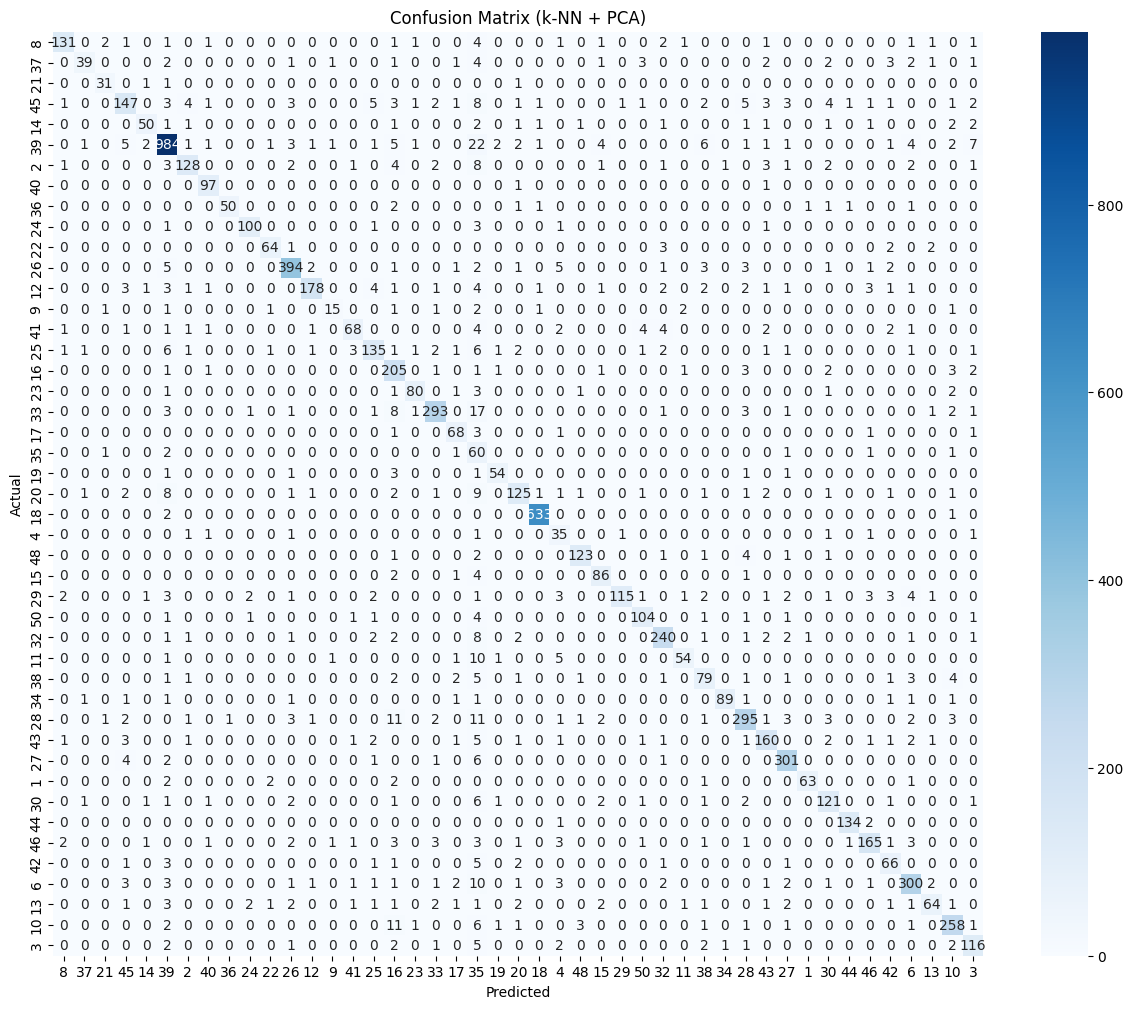

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names=y_test.unique()


# Predictions on the test set using PCA
test_predictions_pca = knn_classifier_pca.predict(X_test_tfidf_pca)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions_pca)

# Set figure size based on the number of classes
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.title('Confusion Matrix (k-NN + PCA)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the plot as an image
plt.savefig(PROJECT_FOLDER+'confusion_matrices/confusion_matrix_knn.png')

# Open the saved image file
import webbrowser
webbrowser.open(PROJECT_FOLDER+'confusion_matrices/confusion_matrix_knn.png')


### Parametro C su SVM

Su SVM, oltre al kernel, il parametro di riferimento è il parametro "C".
"C" in SVM è un parametro di regolarizzazione che controlla il trade-off tra la complessità del modello e la precisione sulla fase di addestramento. Un valore più elevato di C permette al modello di adattarsi meglio ai dati di addestramento, ma potrebbe portare a un'iper-regolarizzazione. D'altro canto, un valore più basso di C favorisce una maggiore generalizzazione, ma potrebbe risultare in una minore precisione sui dati di addestramento.


In [ ]:


max_accuracy=0
best_C_param=0
# Train SVM classifier on the PCA-transformed features with an RBF kernel
for i in [1,2,3,4,5]:

  print("addestramento kernel rdf, C="+str(i))
  svm_classifier_pca = SVC(kernel='rbf',C=i)  # Use 'rbf' for non-linear kernel
  svm_classifier_pca.fit(X_train_tfidf_pca, y_train)

# Predictions on the validation set using PCA
  val_predictions_pca_svm = svm_classifier_pca.predict(X_val_tfidf_pca)

# Evaluate the model with PCA-transformed features
  accuracy_pca_svm = accuracy_score(y_val, val_predictions_pca_svm)
  print("SVM + PCA Accuracy:", accuracy_pca_svm)
  if max_accuracy < accuracy_pca_svm:
    max_accuracy=accuracy_pca_svm
    best_C_param=i


print(f"best C parameter is {best_C_param}")

addestramento kernel rdf, C=1
SVM + PCA Accuracy: 0.9541728763040238
addestramento kernel rdf, C=2
SVM + PCA Accuracy: 0.9606308991554893
addestramento kernel rdf, C=3
SVM + PCA Accuracy: 0.96274217585693
addestramento kernel rdf, C=4
SVM + PCA Accuracy: 0.9623695976154992
addestramento kernel rdf, C=5
SVM + PCA Accuracy: 0.9623695976154992
best C parameter is 3


Una volta ottenuto il miglior valore per il parametro C, testiamo il modello sullo split "test".

In [ ]:
# Apply PCA
X_test_tfidf_pca = pca.transform(X_test_tfidf.toarray())

svm_classifier_pca = SVC(kernel='rbf',C=3)  # Use 'rbf' for non-linear kernel
svm_classifier_pca.fit(X_train_tfidf_pca, y_train)

# Predictions on the validation set using PCA
test_predictions_pca_svm = svm_classifier_pca.predict(X_test_tfidf_pca)

# Evaluate the model with PCA-transformed features
accuracy_pca_svm = accuracy_score(y_test, test_predictions_pca_svm)
print("SVM + PCA Accuracy:", accuracy_pca_svm)
print("\nClassification Report (PCA):")
print(classification_report(y_test, test_predictions_pca_svm))

SVM + PCA Accuracy: 0.960134128166915

Classification Report (PCA):
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       151
           2       0.98      0.94      0.96        64
           3       0.97      0.91      0.94        34
           4       0.87      0.84      0.86       206
           6       0.97      0.94      0.95        67
           8       0.95      0.98      0.96      1061
           9       0.98      0.96      0.97       161
          10       1.00      0.97      0.98        99
          11       0.96      0.95      0.96        58
          12       0.98      0.94      0.96       107
          13       0.97      0.94      0.96        72
          14       0.99      0.98      0.99       422
          15       0.98      0.98      0.98       212
          16       0.95      0.81      0.88        26
          17       0.93      0.92      0.93        93
          18       0.93      0.96      0.95       170
          19 

Questo è il miglior risultato ottenuto finora. Qui sotto la confusion matrix dell'applicazione del modello sullo split "test" di dati.

False

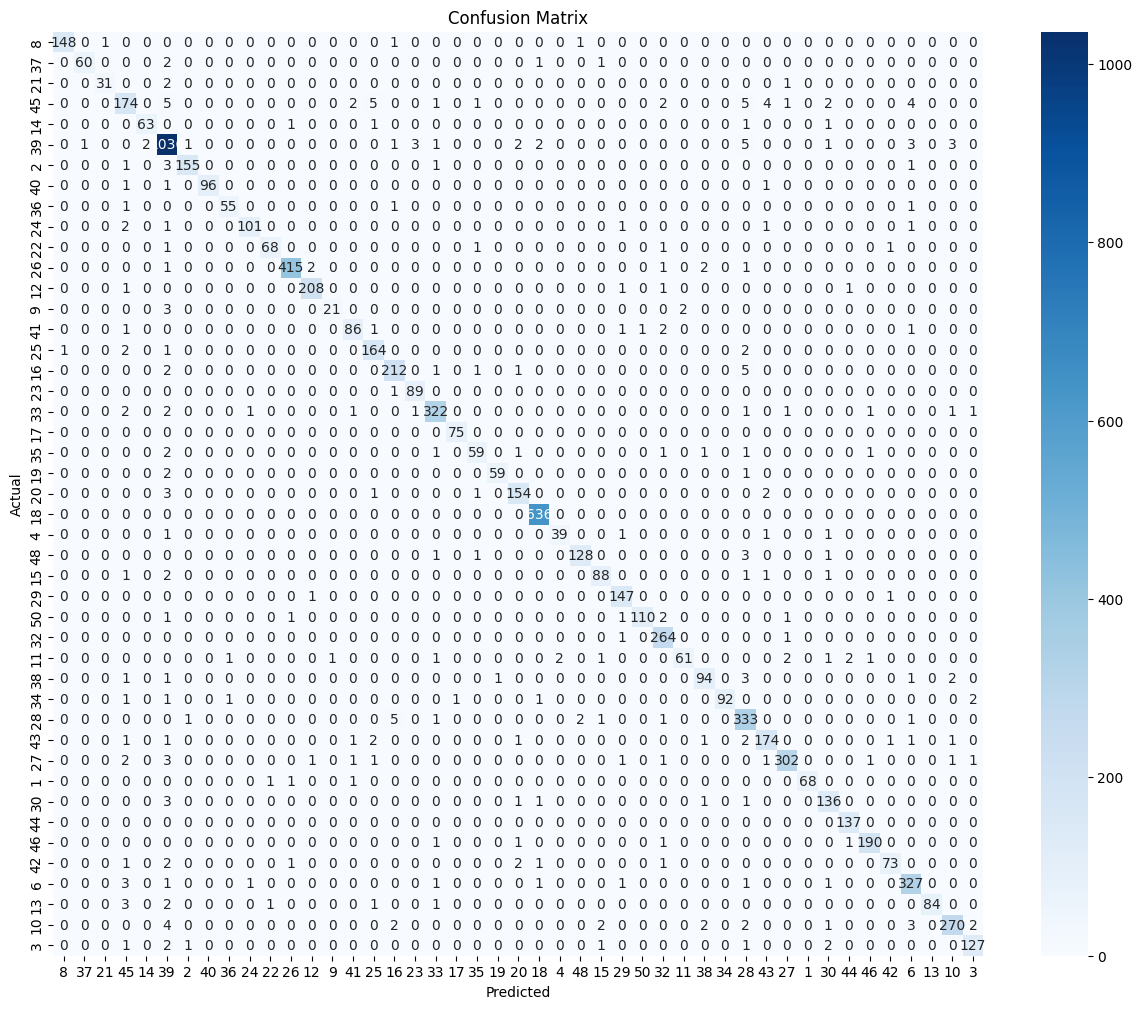

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
class_names=y_test.unique()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions_pca_svm)

# Set figure size based on the number of classes
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the plot as an image
plt.savefig(PROJECT_FOLDER+'confusion_matrices/confusion_matrix_SVM.png')

# Open the saved image file
import webbrowser
webbrowser.open(PROJECT_FOLDER+'confusion_matrices/confusion_matrix_SVM.png')



gradient boost adaboost random forests.

### Logistic regression

Per linear regression i parametri sono: C, penalty values e max_iter.

Il modello di logistic regression ha diversi iperparametri che possono essere soggetti a tuning per ottimizzare le prestazioni. Alcuni dei principali iperparametri includono:

1. **C**: Parametro di regolarizzazione, che controlla l'inversione della matrice dei coefficienti. Valori più alti di C portano a una regolarizzazione più debole.

2. **penalty**: Specifica il tipo di regolarizzazione da applicare.

3. **max_iter**: Numero massimo di iterazioni per la convergenza del solver.



In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Lista dei valori da esplorare per C, penalty e max_iter
C_values = [0.01, 0.1, 1, 10, 100]
penalty_values = ['l2']
max_iter_values = [100, 500, 1000, 1500]

best_accuracy = 0
best_params = {}

for C in C_values:
    for penalty in penalty_values:
        for max_iter in max_iter_values:
            # Creazione del modello con i parametri correnti
            logistic_regression_model = LogisticRegression(C=C, penalty=penalty, max_iter=max_iter)

            # Addestramento del modello
            logistic_regression_model.fit(X_train_tfidf, y_train)

            # Previsioni sul set di eval
            val_predictions_tfidf = logistic_regression_model.predict(X_val_tfidf)

            # Calcolo dell'accuratezza
            accuracy_tfidf = accuracy_score(y_val, val_predictions_tfidf)
            print(f"accuract of max_iter:{max_iter} C:{C} and penalty:{penalty} is {accuracy_tfidf}")

            # Aggiornamento dei migliori parametri se l'accuratezza è migliorata
            if accuracy_tfidf > best_accuracy:
                best_accuracy = accuracy_tfidf
                best_params = {'C': C, 'penalty': penalty, 'max_iter': max_iter}

# Stampa dei migliori parametri e accuratezza
print("Migliori parametri:", best_params)
print("Logistic Regression + TF-IDF Accuracy:", best_accuracy)


accuract of max_iter:100 C:0.01 and penalty:l2 is 0.24826130153999007
accuract of max_iter:500 C:0.01 and penalty:l2 is 0.24826130153999007
accuract of max_iter:1000 C:0.01 and penalty:l2 is 0.24826130153999007
accuract of max_iter:1500 C:0.01 and penalty:l2 is 0.24826130153999007
accuract of max_iter:100 C:0.1 and penalty:l2 is 0.6759811227024342
accuract of max_iter:500 C:0.1 and penalty:l2 is 0.6759811227024342
accuract of max_iter:1000 C:0.1 and penalty:l2 is 0.6759811227024342
accuract of max_iter:1500 C:0.1 and penalty:l2 is 0.6759811227024342


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuract of max_iter:100 C:1 and penalty:l2 is 0.9297069051167411
accuract of max_iter:500 C:1 and penalty:l2 is 0.9298310978638847
accuract of max_iter:1000 C:1 and penalty:l2 is 0.9298310978638847
accuract of max_iter:1500 C:1 and penalty:l2 is 0.9298310978638847


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuract of max_iter:100 C:10 and penalty:l2 is 0.9672131147540983
accuract of max_iter:500 C:10 and penalty:l2 is 0.9665921510183805
accuract of max_iter:1000 C:10 and penalty:l2 is 0.9665921510183805
accuract of max_iter:1500 C:10 and penalty:l2 is 0.9665921510183805


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuract of max_iter:100 C:100 and penalty:l2 is 0.970442126179831
accuract of max_iter:500 C:100 and penalty:l2 is 0.9726775956284153
accuract of max_iter:1000 C:100 and penalty:l2 is 0.9726775956284153
accuract of max_iter:1500 C:100 and penalty:l2 is 0.9726775956284153
Migliori parametri: {'C': 100, 'penalty': 'l2', 'max_iter': 500}
Logistic Regression + TF-IDF Accuracy: 0.9726775956284153


Il modello migliore si ottiene con un valore alto di C.
C'è però da ricordare che in regressione logistica, il parametro `C` rappresenta l'inverso della forza di regolarizzazione. Un valore di `C` maggiore corrisponde a una regolarizzazione più debole.

1. **`C` più Piccolo (Regolarizzazione Forte):** Un valore più piccolo di `C` applica una regolarizzazione più forte, tendendo a ridurre i coefficienti verso zero. Questo può contribuire a prevenire l'overfitting penalizzando i valori elevati dei coefficienti.

2. **`C` più Grande (Regolarizzazione Debole):** Un valore più grande di `C` indica una regolarizzazione più debole. In questo caso, il modello è meno vincolato per quanto riguarda i coefficienti e potrebbe adattarsi più strettamente ai dati di addestramento. Questo può essere vantaggioso quando i dati di addestramento sono rumorosi o quando si desidera che il modello catturi pattern più complessi.

La scelta del valore appropriato per `C` comporta un compromesso. Una regolarizzazione eccessiva (`C` troppo piccolo) può portare a un underfitting, mentre una regolarizzazione insufficiente (`C` troppo grande) può causare overfitting.

Per questo conviene vedere come performa sui dati dello split "test", perchè ci potrebbe essere stato overfitting sui dati.

In [72]:

  # Train Logistic Regression classifier on TF-IDF vectors
logistic_regression_classifier_tfidf = LogisticRegression(C=100,penalty='l2',max_iter=500)
logistic_regression_classifier_tfidf.fit(X_train_tfidf, y_train)

# Predictions on the validation set using TF-IDF
test_predictions_tfidf = logistic_regression_classifier_tfidf.predict(X_test_tfidf)

# Evaluate the TF-IDF model with Logistic Regression
accuracy_tfidf = accuracy_score(y_test, test_predictions_tfidf)
print("Logistic Regression + TF-IDF Accuracy:", accuracy_tfidf)
print("\nClassification Report (TF-IDF):")
print(classification_report(y_test, test_predictions_tfidf))

Logistic Regression + TF-IDF Accuracy: 0.9728017883755589

Classification Report (TF-IDF):
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       151
           2       1.00      0.91      0.95        64
           3       1.00      0.91      0.95        34
           4       0.93      0.85      0.89       206
           6       0.96      0.96      0.96        67
           8       0.97      0.98      0.98      1061
           9       0.98      0.99      0.98       161
          10       0.99      0.98      0.98        99
          11       0.98      0.95      0.96        58
          12       1.00      0.96      0.98       107
          13       1.00      0.99      0.99        72
          14       0.98      0.99      0.99       422
          15       0.97      1.00      0.98       212
          16       0.93      0.96      0.94        26
          17       0.98      0.96      0.97        93
          18       0.96      0.99      0.97 

False

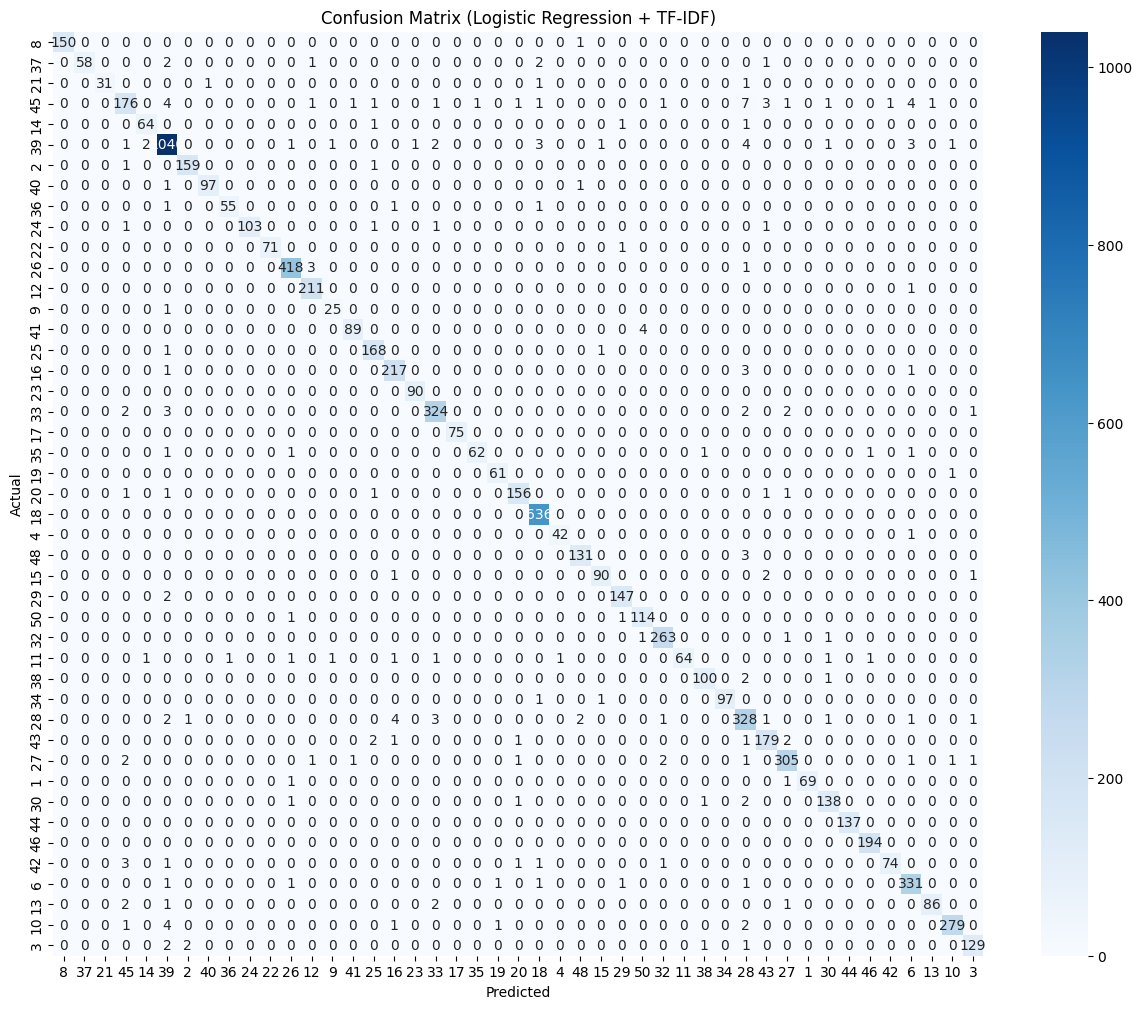

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
class_names=y_test.unique()


# Predictions on the test set using TF-IDF
test_predictions_tfidf = logistic_regression_classifier_tfidf.predict(X_test_tfidf)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions_tfidf)

# Set figure size based on the number of classes
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.title('Confusion Matrix (Logistic Regression + TF-IDF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the plot as an image
plt.savefig(PROJECT_FOLDER+'confusion_matrices/confusion_matrix_logistic_regression.png')

# Open the saved image file
import webbrowser
webbrowser.open(PROJECT_FOLDER+'confusion_matrices/confusion_matrix_logistic_regression.png')


## Conclusioni

Ricapitolando, per risolvere il task di authorship attribuition, abbiamo testato due diverse tecnologie di vettorizzazione: Tf-IDF e Word2Vec. Constatando che TF-idf portava risultati migliori.
Abbiamo poi testato diversi modelli di classificazione:
1. Naive Bayes
2. Logistic Regression
3. KNN
4. SVM
5. Decision tree+ Adaboost

Tra questi abbiamo preso i tre modelli di classificazione che hanno dato i migliori risultati: SVM, KNN e Logistic Regression, ed abbiamo svolto una fase di parameter Tuning.
Due modelli hanno dato le migliori prestazioni:
- Logistic Regression
- SVM
Considerando, però, che per ottenere performance equivalenti ad SVM con logistic regression, abbiamo dovuto aumentare sensibilmente il valore C, potrebbe essere saggio utilizzare SVM, che ci garantisce una maggiore resistenza all'overfitting, e che potrebbe quindi essere più adatto a nuovi dati non provenienti dal dataset.